In [1]:
import pickle
import argparse
import os
import pandas as pd
import plot_util
from pathlib import Path
from importlib import reload

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

REVIEWS_TESTING_OUTPUTS_DIR = "../review_testing_outputs"
SENTENCES_TESTING_OUTPUTS_DIR = "../sentence_testing_outputs"

%matplotlib notebook
bargraph_savepath = "../sentence_testing_outputs/plots/reviews_with_negation"
plot_type = "negation_positive_plot"

names_map = {
    "yelp": "Yelp", 
    "imdb": "IMDB", 
    "tripadvisor": "Tripadvisor", 
    "cellphones_and_accessories": "Cellphones", 
    "pet_supplies": "Pet Supplies",
    "automotive": "Automotive", 
    "luxury_beauty": "Luxury Beauty", 
    "sports_and_outdoors": "Sports", 
}

In [2]:
def read_and_load_model_outputs(correction_score, label, testing_outputs_dir):
    plot_df = pd.DataFrame()
    for d in list(names_map.keys()):
        if True:
            pos_file = os.path.join(testing_outputs_dir, d, "pos_sents_test")        
            neg_file = os.path.join(testing_outputs_dir, d, "neg_sents_test")

            data_pos = pickle.load(open(pos_file, "rb"))
            data_neg = pickle.load(open(neg_file, "rb"))

            pos_file_review_testing = os.path.join(REVIEWS_TESTING_OUTPUTS_DIR, d, "pos_reviews_test")        
            neg_file_review_testing = os.path.join(REVIEWS_TESTING_OUTPUTS_DIR, d, "neg_reviews_test")
            
            data_pos_review_testing = pickle.load(open(pos_file_review_testing, "rb"))
            data_neg_review_testing = pickle.load(open(neg_file_review_testing, "rb"))
            
            dataset_name = data_pos["name"].to_list()[0]
            if plot_type == "normal_plot":
                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "review_category": "positive",
                    "accuracy": data_pos["accuracy"].to_list()[0]*100,
                }, ignore_index=True)

                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "review_category": "negative",
                    "accuracy": data_neg["accuracy"].to_list()[0]*100,
                }, ignore_index=True)
            elif plot_type == "negation_positive_plot":
                if label == "positive":
                    data_df_plot = data_pos
                    data_df_plot_review_testing = data_pos_review_testing
                else:
                    data_df_plot = data_neg
                    data_df_plot_review_testing = data_neg_review_testing

                if correction_score == True:
                    correct_count = data_df_plot_review_testing["correct_count"].to_list()[0]
                    total_count = data_df_plot_review_testing["total_count"].to_list()[0]
                    accuracy = data_df_plot["accuracy"].to_list()[0]
                    true_rate = correct_count/total_count
                    false_rate = (total_count-correct_count)/total_count
                    acc = true_rate*accuracy + false_rate*(1-accuracy)
                else:                    
                    acc = data_df_plot["correct_count"].to_list()[0]/data_df_plot["total_count"].to_list()[0]

                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "all sentences",
                    "accuracy": acc*100,
                }, ignore_index=True)

                acc = data_df_plot["correct_count_with_negation"].to_list()[0]/data_df_plot["total_negation_count"].to_list()[0]
                if correction_score == True:
                    # accuracy = data_df_plot["accuracy"].to_list()[0]
                    true_rate = data_df_plot_review_testing["correct_count_with_negation"].to_list()[0]/ \
                        data_df_plot_review_testing["total_negation_count"].to_list()[0]
                    false_rate = data_df_plot_review_testing["incorrect_count_with_negation"].to_list()[0]/ \
                        data_df_plot_review_testing["total_negation_count"].to_list()[0]
                    acc = true_rate*acc + false_rate*(1-acc)


                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "sentences with negation",
                    "accuracy": acc*100,
                }, ignore_index=True)

                acc = data_df_plot["correct_count_with_pos_words"].to_list()[0]/data_df_plot["total_count_with_pos_words"].to_list()[0]
                if correction_score == True:                    
                    true_rate = data_df_plot_review_testing["correct_count_with_pos_words"].to_list()[0]/ \
                        data_df_plot_review_testing["total_count_with_pos_words"].to_list()[0]
                    false_rate = data_df_plot_review_testing["incorrect_count_with_pos_words"].to_list()[0]/ \
                        data_df_plot_review_testing["total_count_with_pos_words"].to_list()[0]
                    acc = true_rate*acc + false_rate*(1-acc)


                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "sentences with positive lexicons",
                    "accuracy": acc*100,
                }, ignore_index=True)

    print(plot_df)
    amazon_names = ['Pet Supplies', 'Luxury Beauty', 'Automotive', 'Cellphones', 'Sports']
    amazon_names = [val for val in amazon_names]   
    if plot_type == "normal_plot":
        colors = [(84/255, 141/255, 255/255),  (84/255, 141/255, 255/255)]*2
    elif plot_type == "negation_positive_plot":
        colors = [(183/255, 183/255, 183/255),(67/255, 144/255, 188/255), (2/255, 72/255, 110/255)]*2

    Path(os.path.join(testing_outputs_dir, "df_outputs")).mkdir(parents=True, exist_ok=True)
    plot_df.to_csv(os.path.join(testing_outputs_dir, "df_outputs",
        'df_outputs_correction_'+str(correction_score)+'_'+plot_type+'_'+label+'_reviews.csv') )


    plot_df_amz = plot_df[plot_df["name"].isin(amazon_names)]
    plot_df_non_amz = plot_df[~plot_df["name"].isin(amazon_names)]

    if label == 'positive':
        y_axis_name = "\% of pos. sentences"
    else:
        y_axis_name = "\% of neg. sentences"

    ylim_top = plot_df_amz.max(axis=0)["accuracy"]
    ylim_top = 1.7*ylim_top

    Path(os.path.dirname(bargraph_savepath)).mkdir(parents=True, exist_ok=True)

    if correction_score:
        save_path = bargraph_savepath+"_"+ label+"_reviews_with_correction"
    else:
        save_path = bargraph_savepath+"_"+ label+"_reviews"

    ylim_top = plot_df_non_amz.max(axis=0)["accuracy"]
    ylim_top = 1.7*ylim_top
    
    plot_util.draw_grouped_barplot_three_subbars(plot_df_amz, colors, "name", "accuracy", 
                                                        "category", save_path+"_amz", 
                                                         y_axis_name="% of neg. sentences",
                                                        figsize=(15,6), position=(0.12,0.1,0.5,0.85),
                                                        bbox_to_anchor=(1, 0.5, 0.2, 0.5),
                                                        amazon_data_flag=True)
    plot_util.draw_grouped_barplot_three_subbars(plot_df_non_amz, colors, "name", "accuracy", 
                                                    "category", save_path+"_non_amz", 
                                                     y_axis_name="% of neg. sentences",
                                                    figsize=(15,6), position=(0.12,0.1,0.5,0.85),
                                                    bbox_to_anchor=(1, 0.5, 0.2, 0.5),
                                                    amazon_data_flag=False)


     accuracy                          category           name
0   75.509960  all sentences                     Yelp         
1   90.727571  sentences with negation           Yelp         
2   66.167690  sentences with positive lexicons  Yelp         
3   68.067912  all sentences                     IMDB         
4   75.656259  sentences with negation           IMDB         
5   63.439250  sentences with positive lexicons  IMDB         
6   69.901056  all sentences                     Tripadvisor  
7   87.357438  sentences with negation           Tripadvisor  
8   60.985421  sentences with positive lexicons  Tripadvisor  
9   74.652224  all sentences                     Cellphones   
10  87.737955  sentences with negation           Cellphones   
11  63.897156  sentences with positive lexicons  Cellphones   
12  75.391880  all sentences                     Pet Supplies 
13  87.499560  sentences with negation           Pet Supplies 
14  66.723911  sentences with positive lexicons  Pet Su

<IPython.core.display.Javascript object>


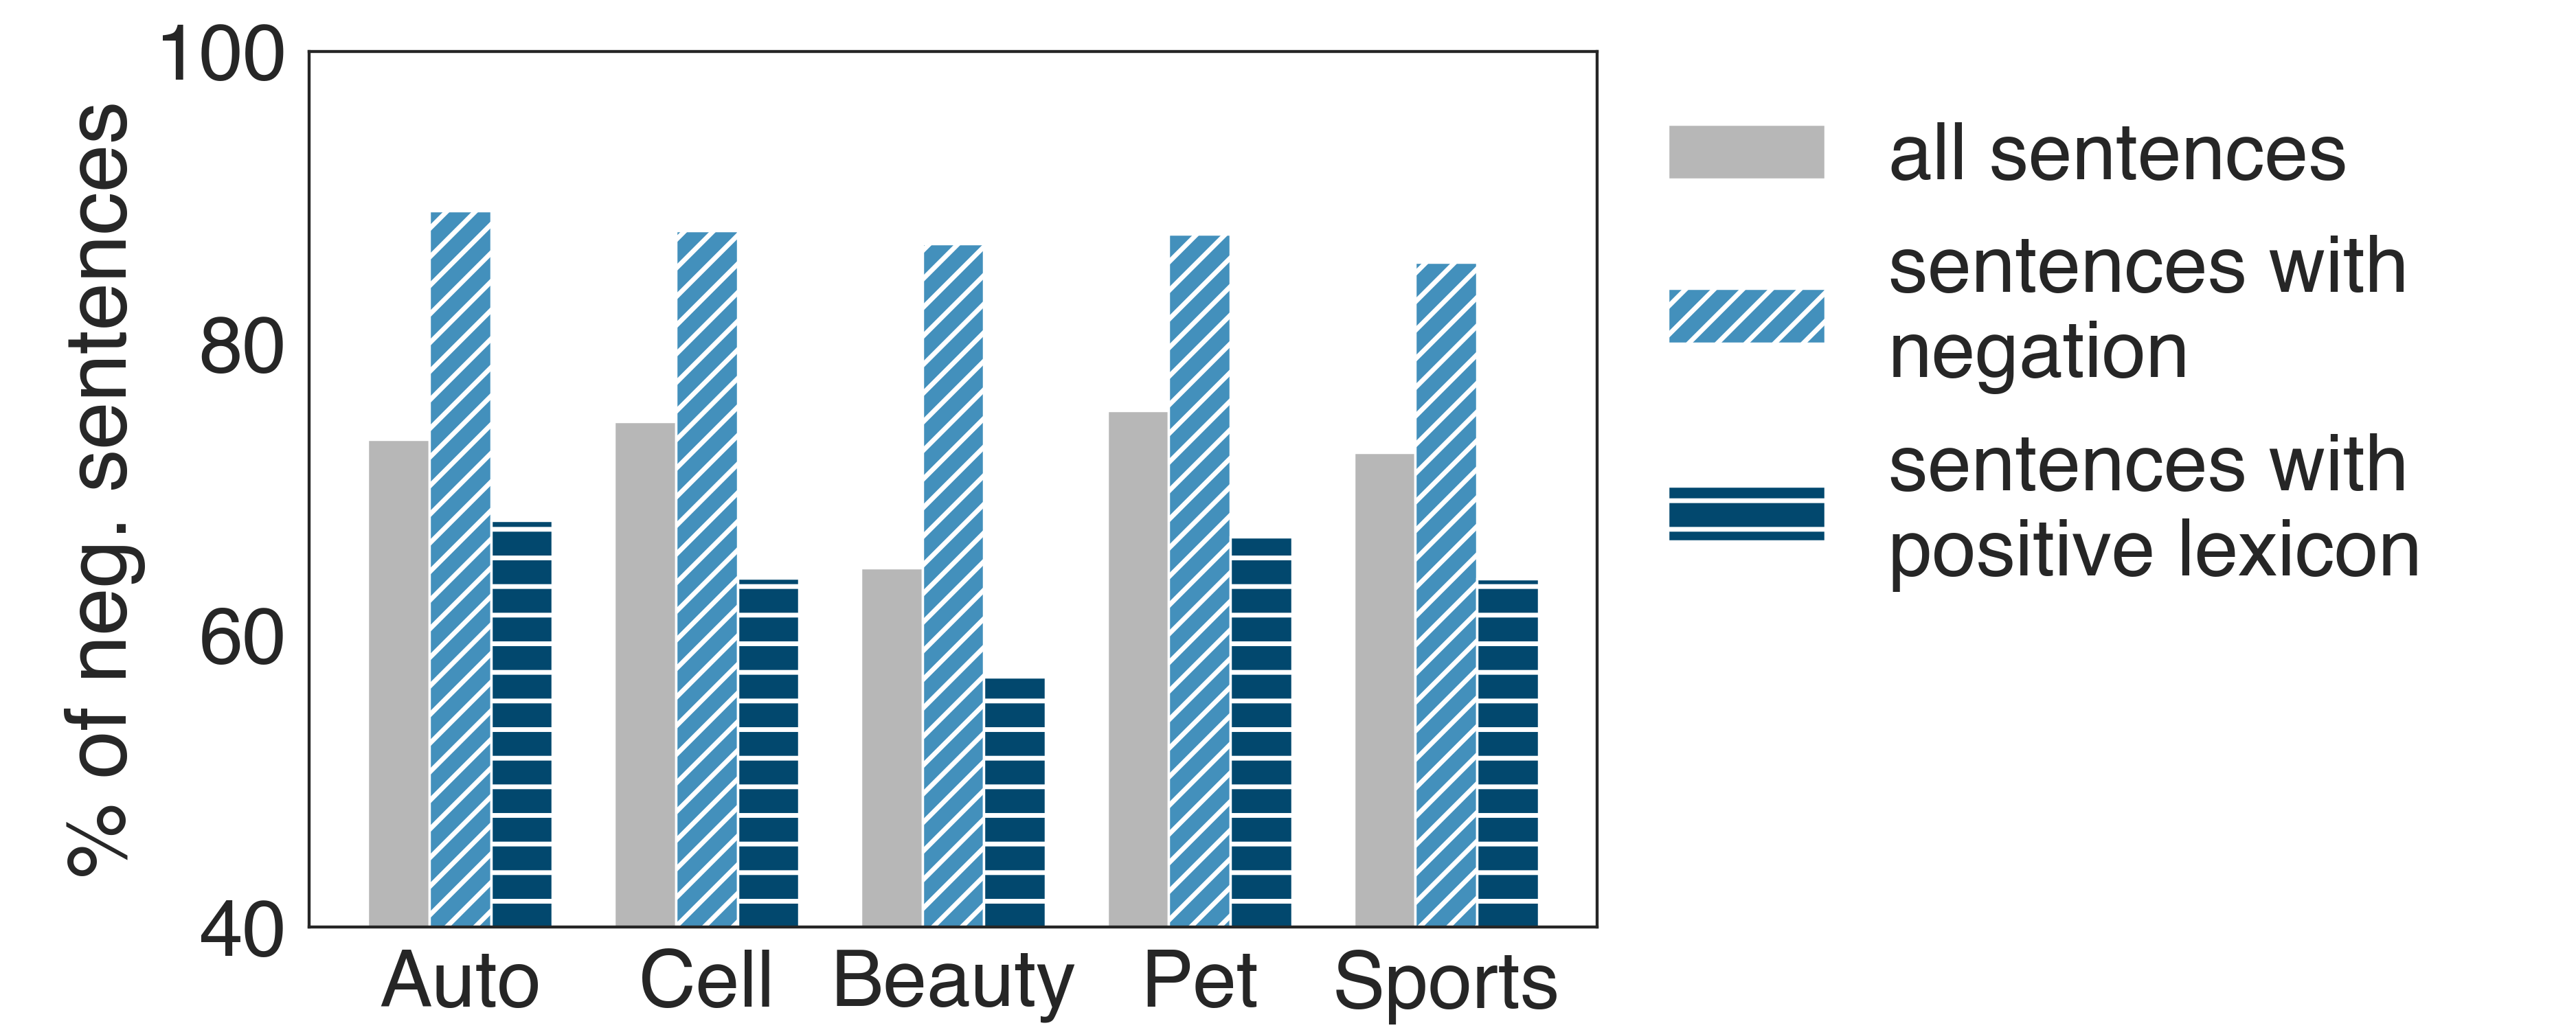

Saving the plot in  ../sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


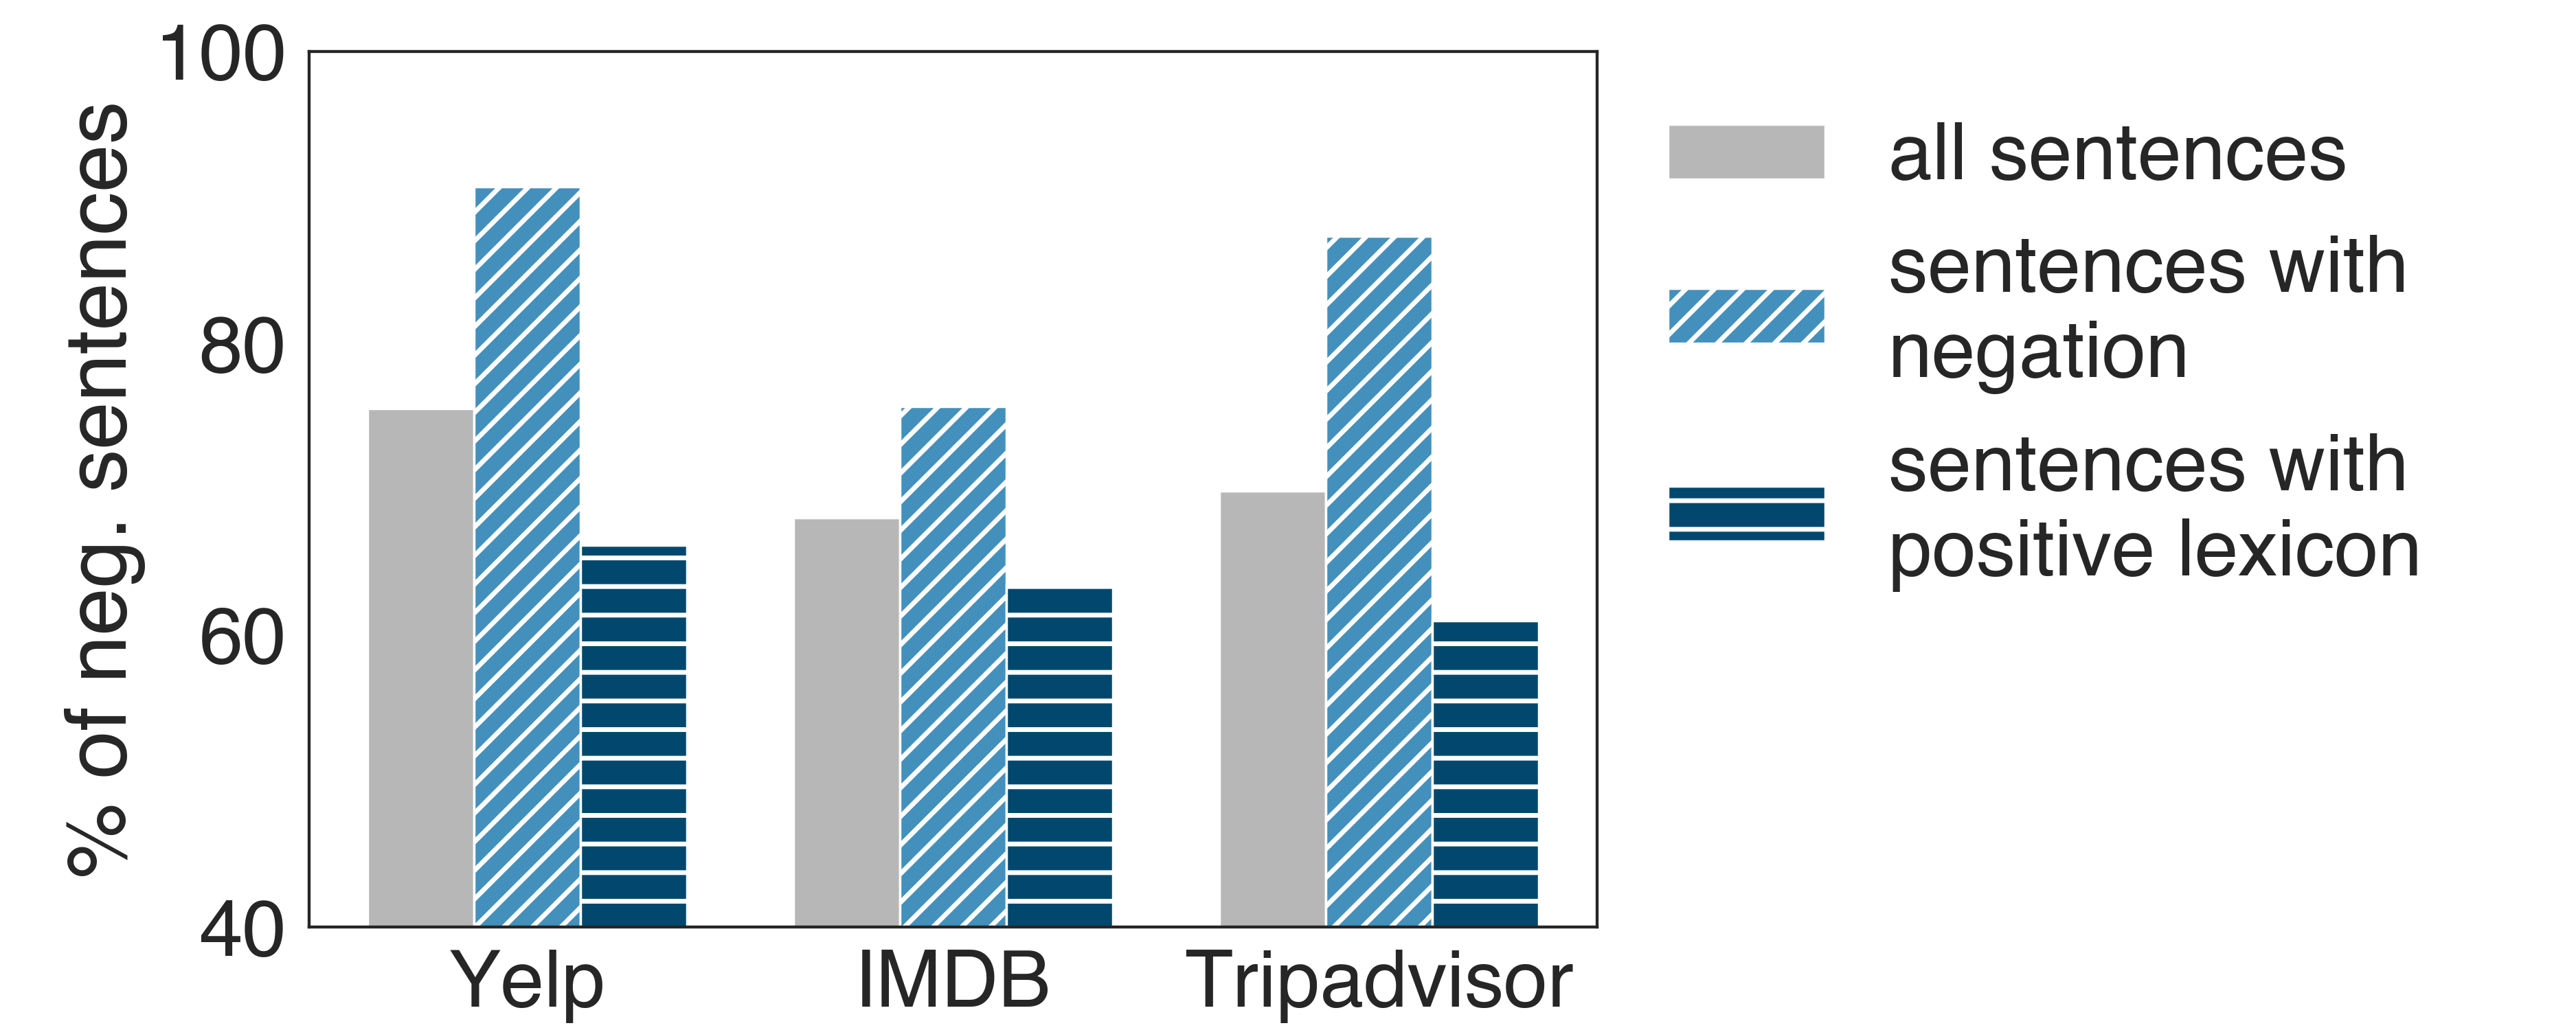

     accuracy                          category           name
0   76.740000  all sentences                     Yelp         
1   92.188919  sentences with negation           Yelp         
2   66.976456  sentences with positive lexicons  Yelp         
3   69.820000  all sentences                     IMDB         
4   77.905945  sentences with negation           IMDB         
5   64.755481  sentences with positive lexicons  IMDB         
6   71.280000  all sentences                     Tripadvisor  
7   89.486166  sentences with negation           Tripadvisor  
8   61.726292  sentences with positive lexicons  Tripadvisor  
9   76.960000  all sentences                     Cellphones   
10  90.289953  sentences with negation           Cellphones   
11  65.623221  sentences with positive lexicons  Cellphones   
12  77.540000  all sentences                     Pet Supplies 
13  90.097629  sentences with negation           Pet Supplies 
14  68.447694  sentences with positive lexicons  Pet Su

<IPython.core.display.Javascript object>


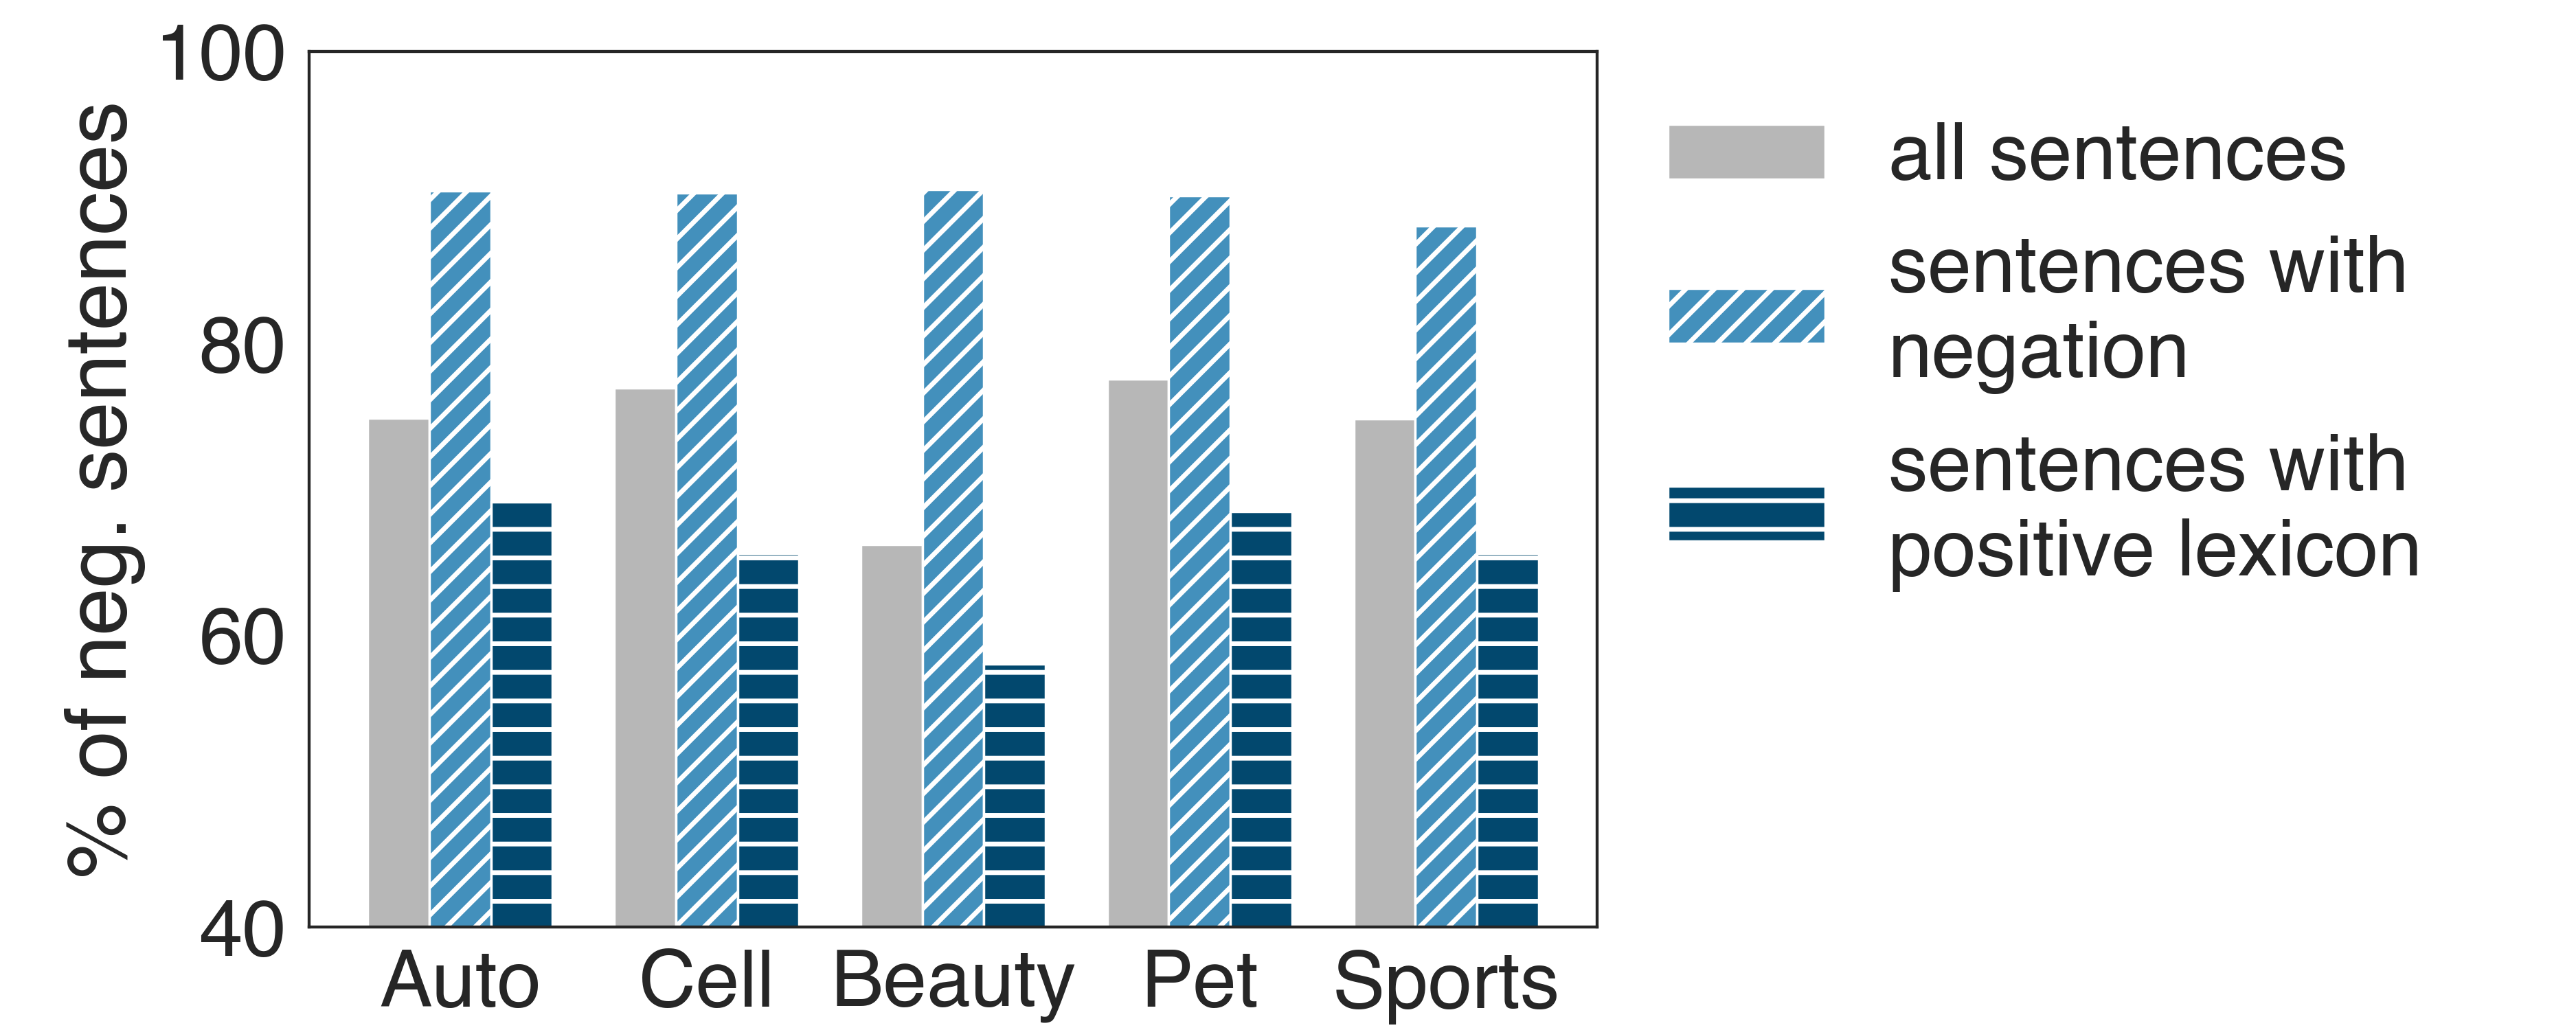

Saving the plot in  ../sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_non_amz


<IPython.core.display.Javascript object>


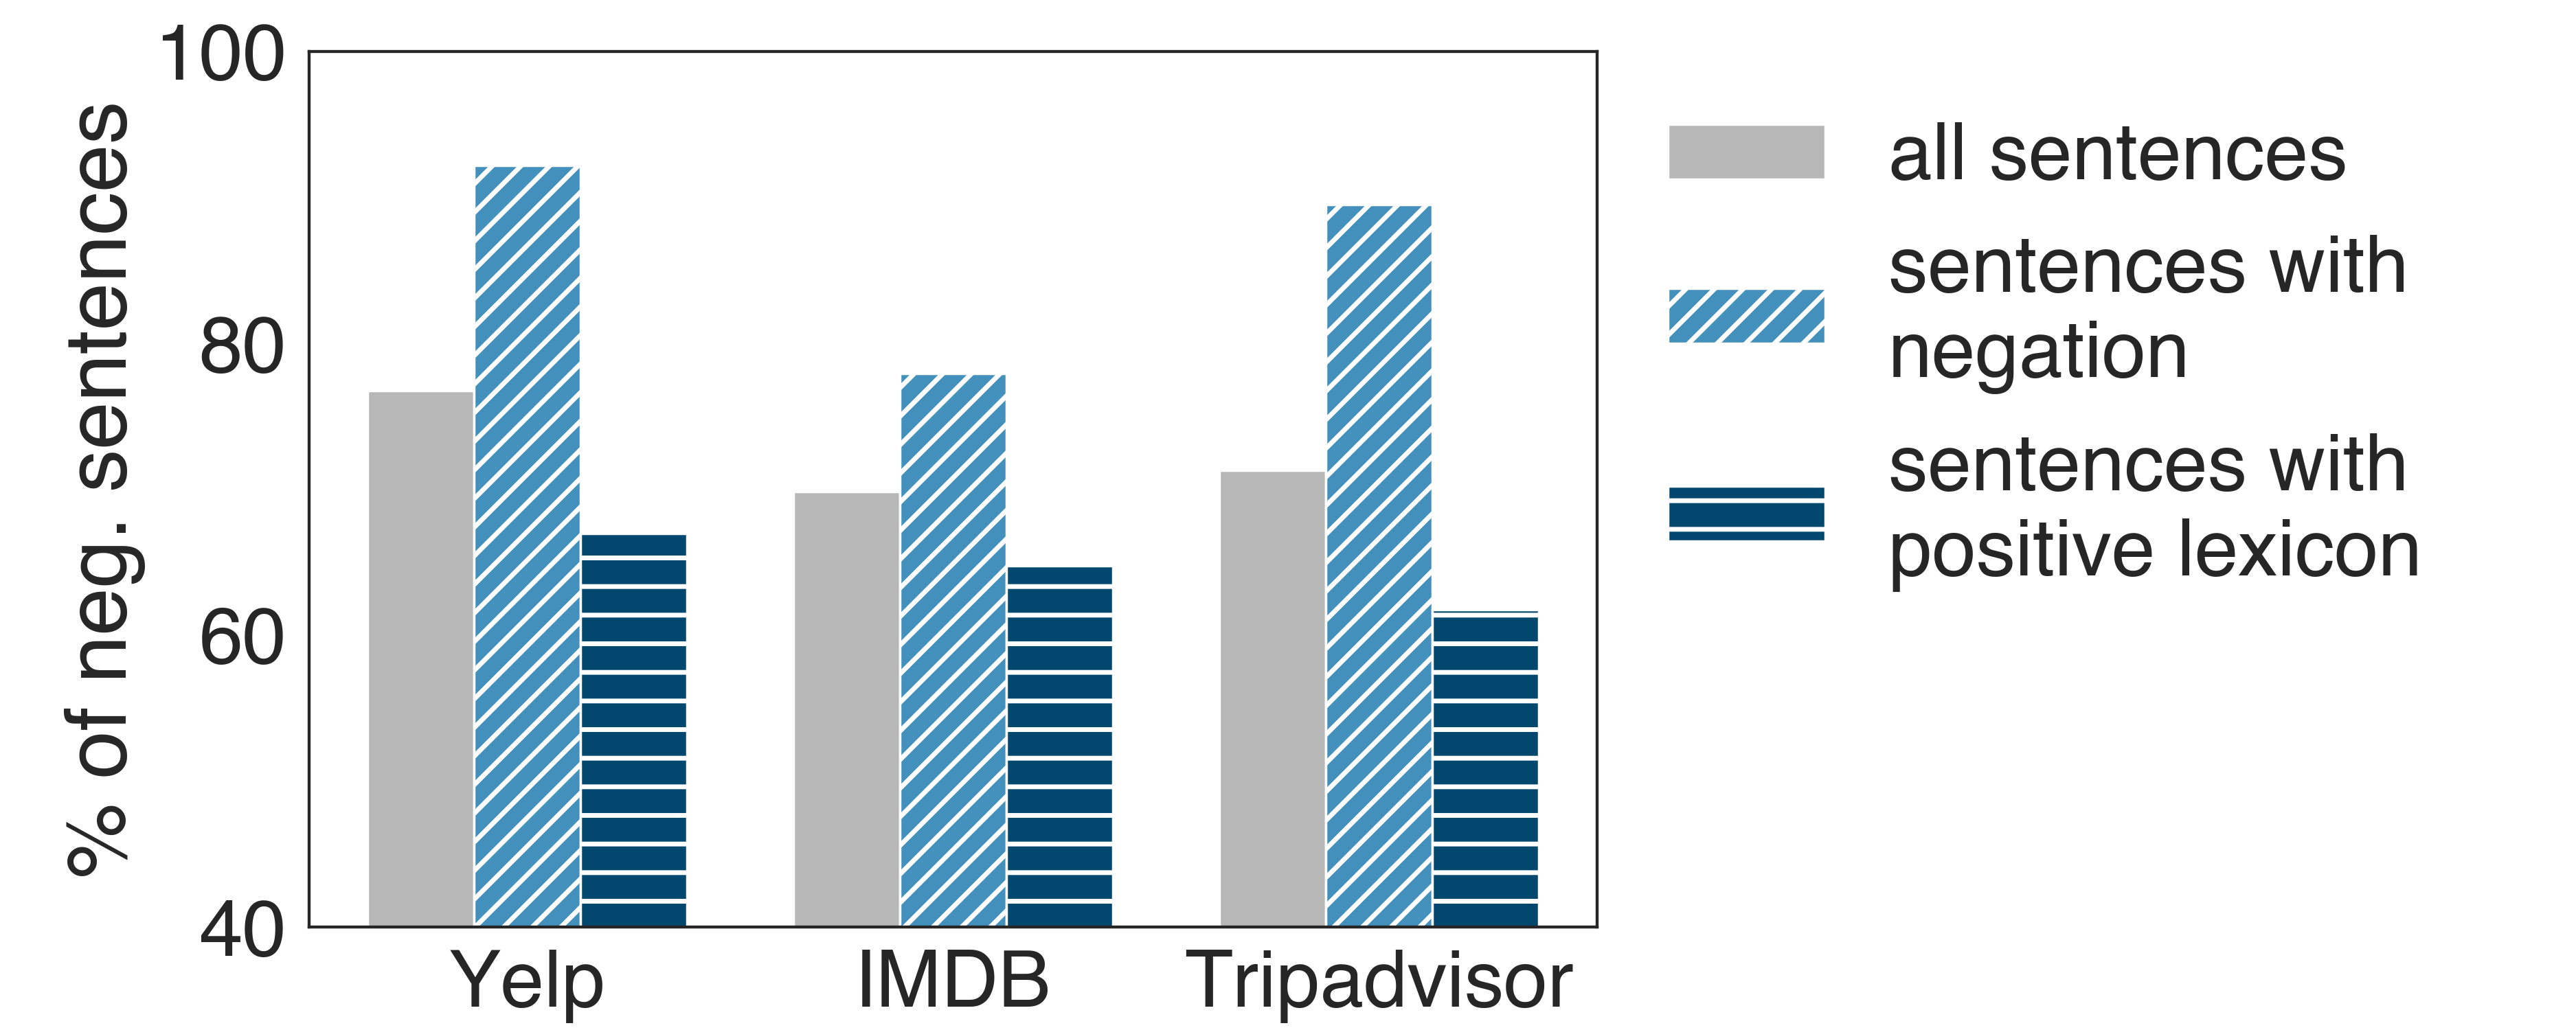

     accuracy                          category           name
0   76.253120  all sentences                     Yelp         
1   52.430687  sentences with negation           Yelp         
2   85.946635  sentences with positive lexicons  Yelp         
3   68.145664  all sentences                     IMDB         
4   57.332147  sentences with negation           IMDB         
5   75.633811  sentences with positive lexicons  IMDB         
6   79.690496  all sentences                     Tripadvisor  
7   58.419868  sentences with negation           Tripadvisor  
8   88.297327  sentences with positive lexicons  Tripadvisor  
9   71.090608  all sentences                     Cellphones   
10  54.828614  sentences with negation           Cellphones   
11  81.780857  sentences with positive lexicons  Cellphones   
12  69.816208  all sentences                     Pet Supplies 
13  52.863145  sentences with negation           Pet Supplies 
14  81.032144  sentences with positive lexicons  Pet Su

<IPython.core.display.Javascript object>


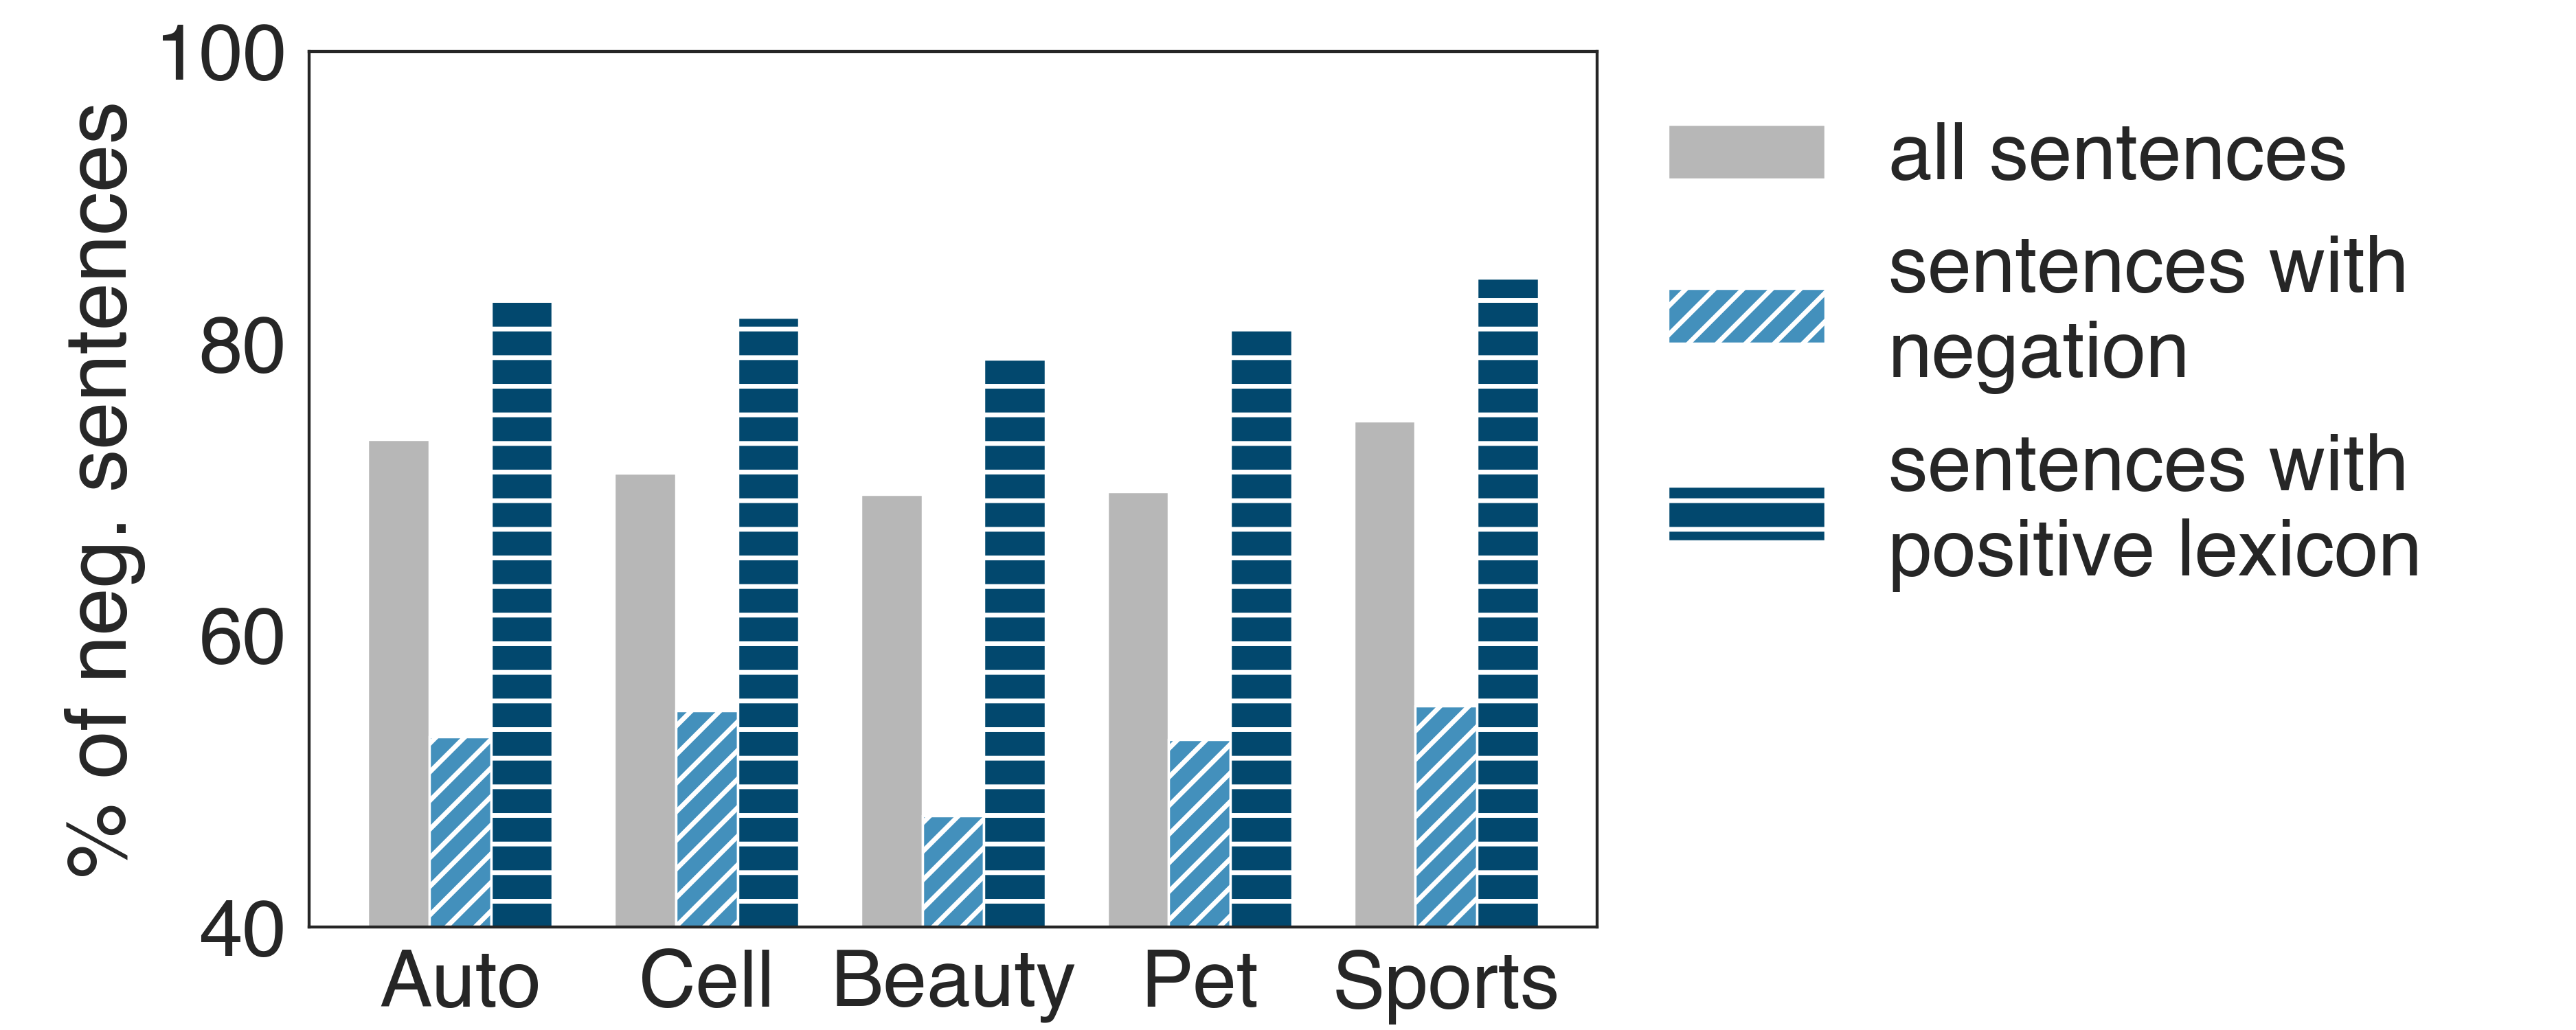

Saving the plot in  ../sentence_testing_outputs/plots/reviews_with_negation_positive_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


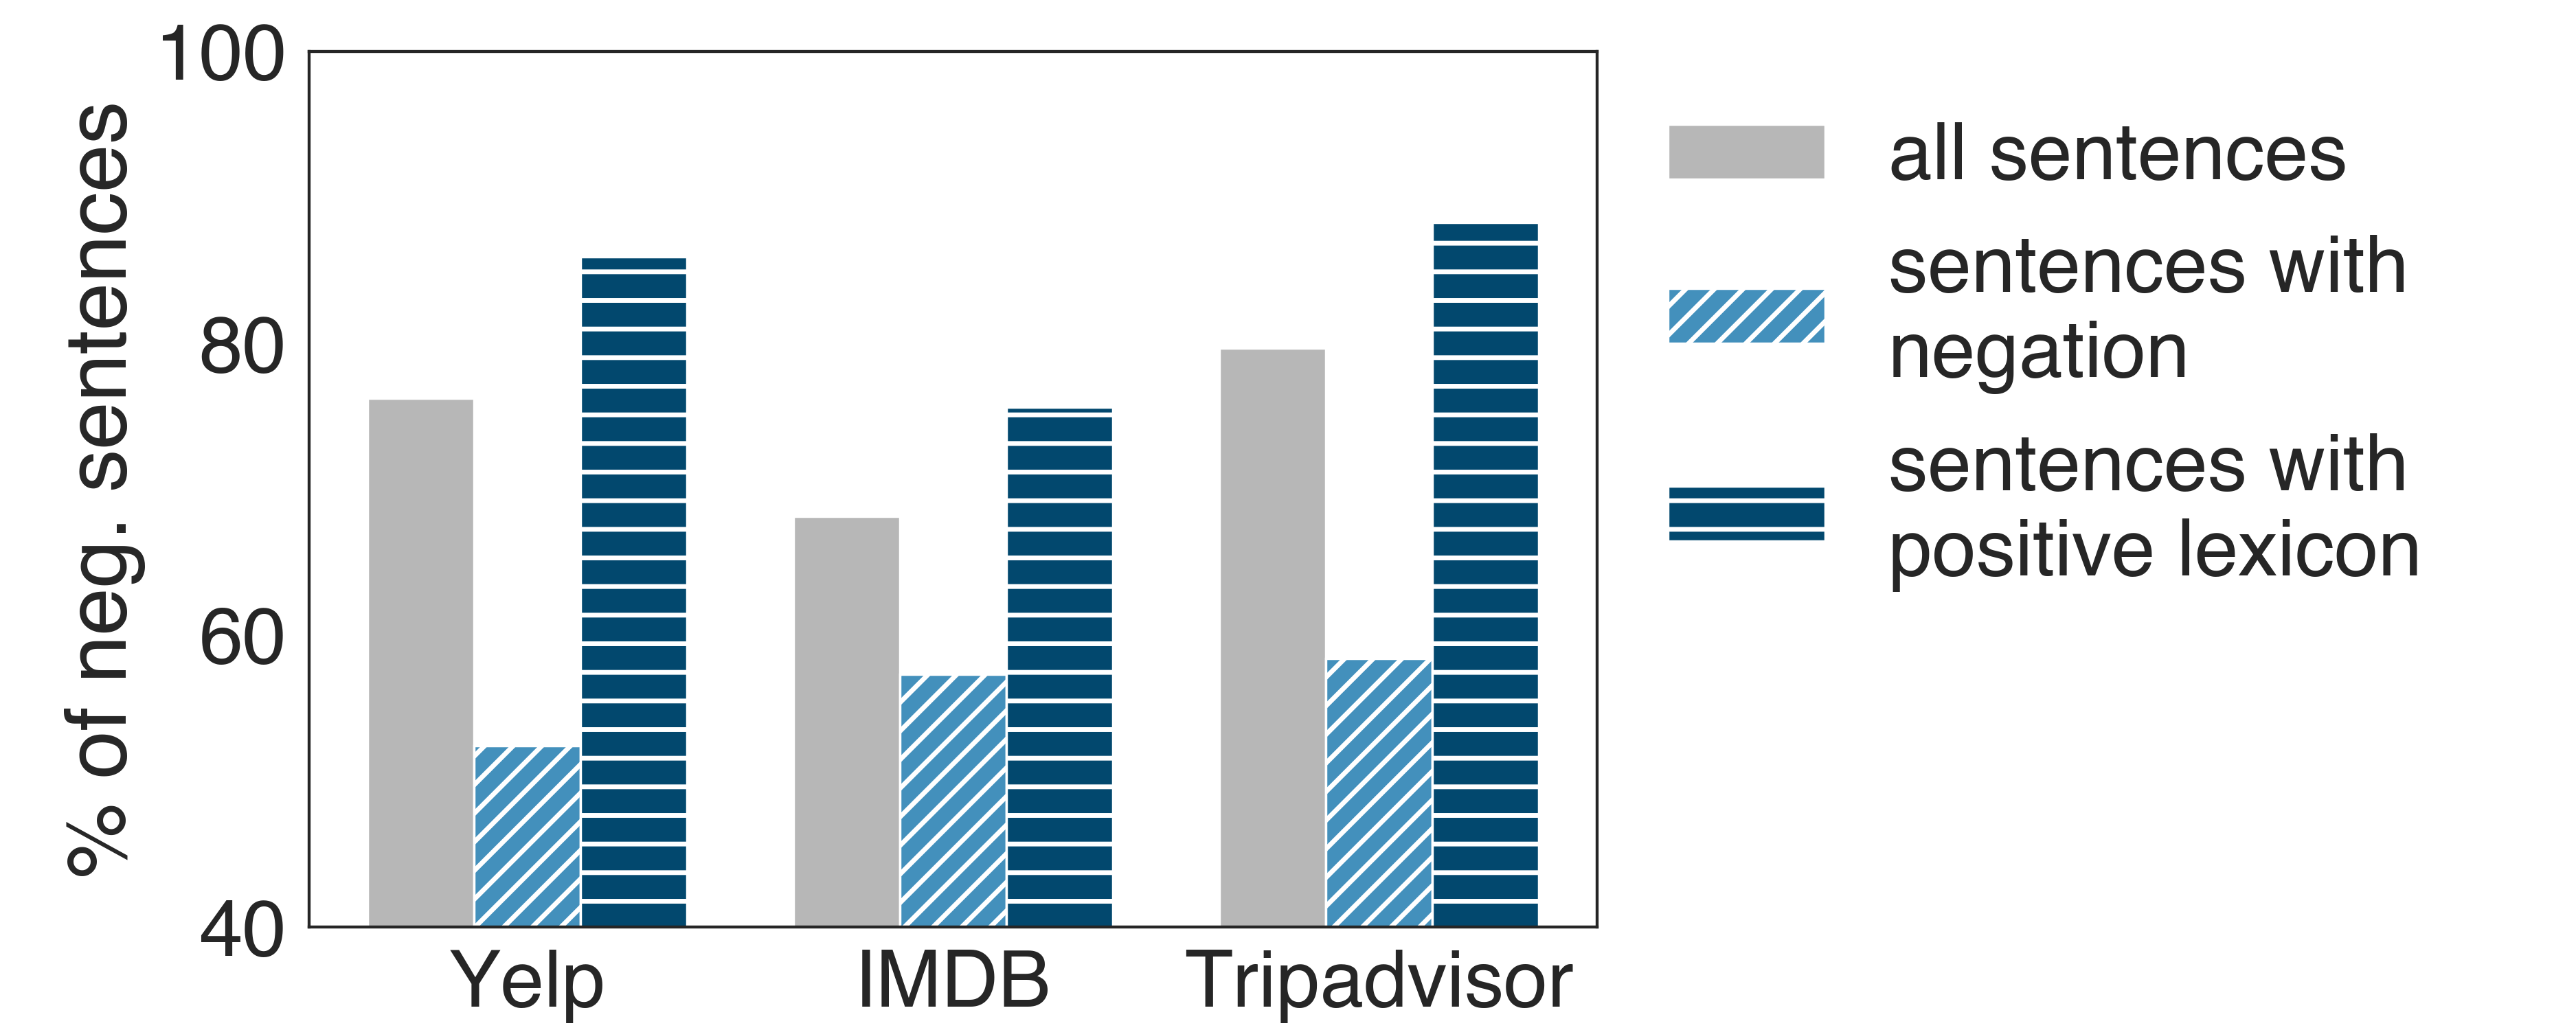

     accuracy                          category           name
0   77.600000  all sentences                     Yelp         
1   52.613828  sentences with negation           Yelp         
2   87.603022  sentences with positive lexicons  Yelp         
3   71.080000  all sentences                     IMDB         
4   58.586957  sentences with negation           IMDB         
5   79.703803  sentences with positive lexicons  IMDB         
6   81.680000  all sentences                     Tripadvisor  
7   59.031414  sentences with negation           Tripadvisor  
8   90.304317  sentences with positive lexicons  Tripadvisor  
9   73.320000  all sentences                     Cellphones   
10  55.762515  sentences with negation           Cellphones   
11  84.529391  sentences with positive lexicons  Cellphones   
12  72.580000  all sentences                     Pet Supplies 
13  53.618031  sentences with negation           Pet Supplies 
14  84.765898  sentences with positive lexicons  Pet Su

<IPython.core.display.Javascript object>


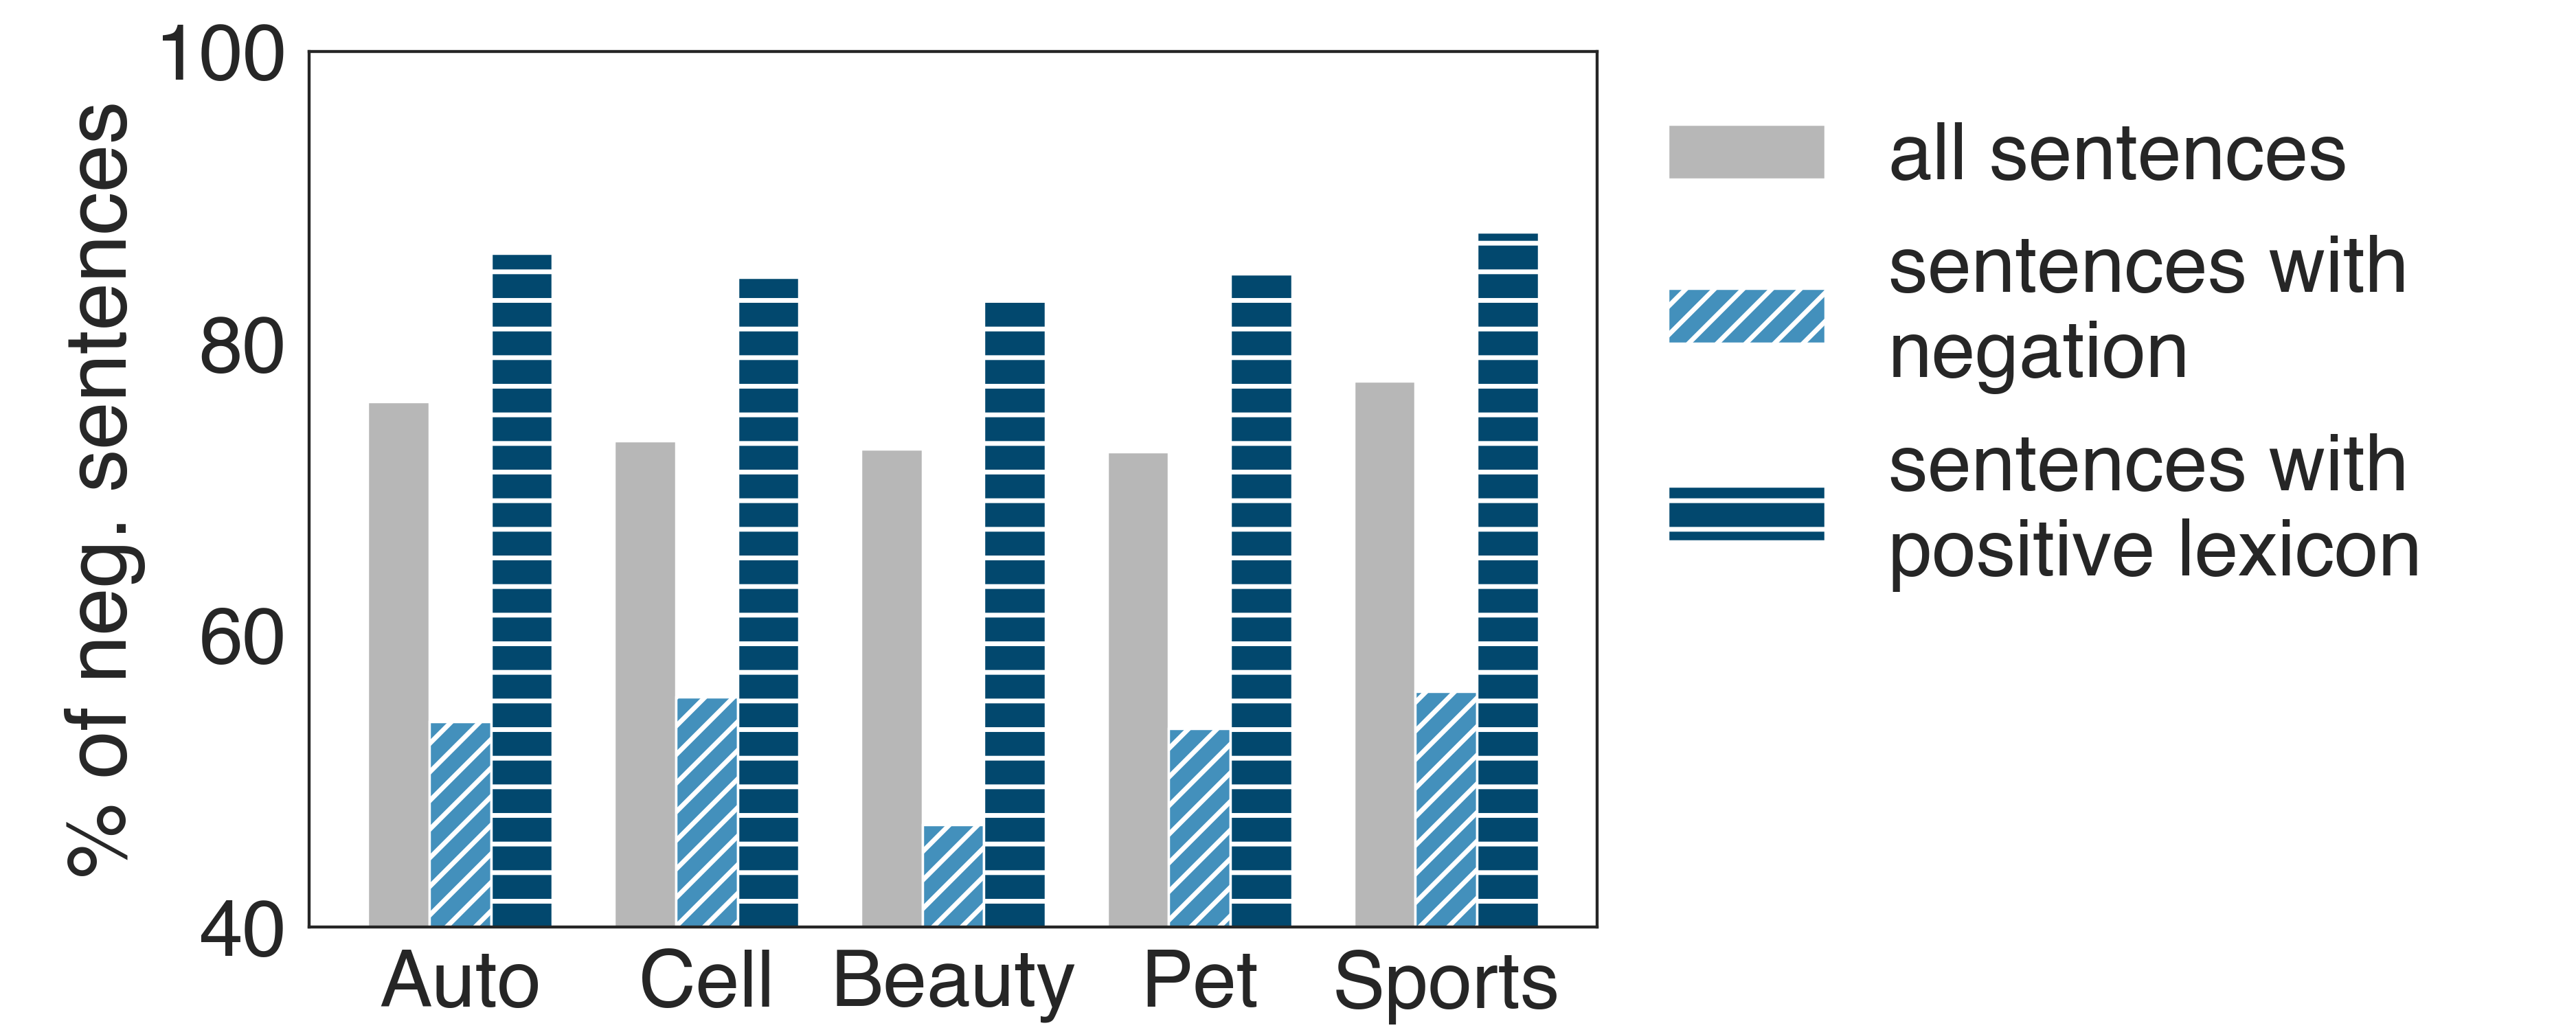

Saving the plot in  ../sentence_testing_outputs/plots/reviews_with_negation_positive_reviews_non_amz


<IPython.core.display.Javascript object>


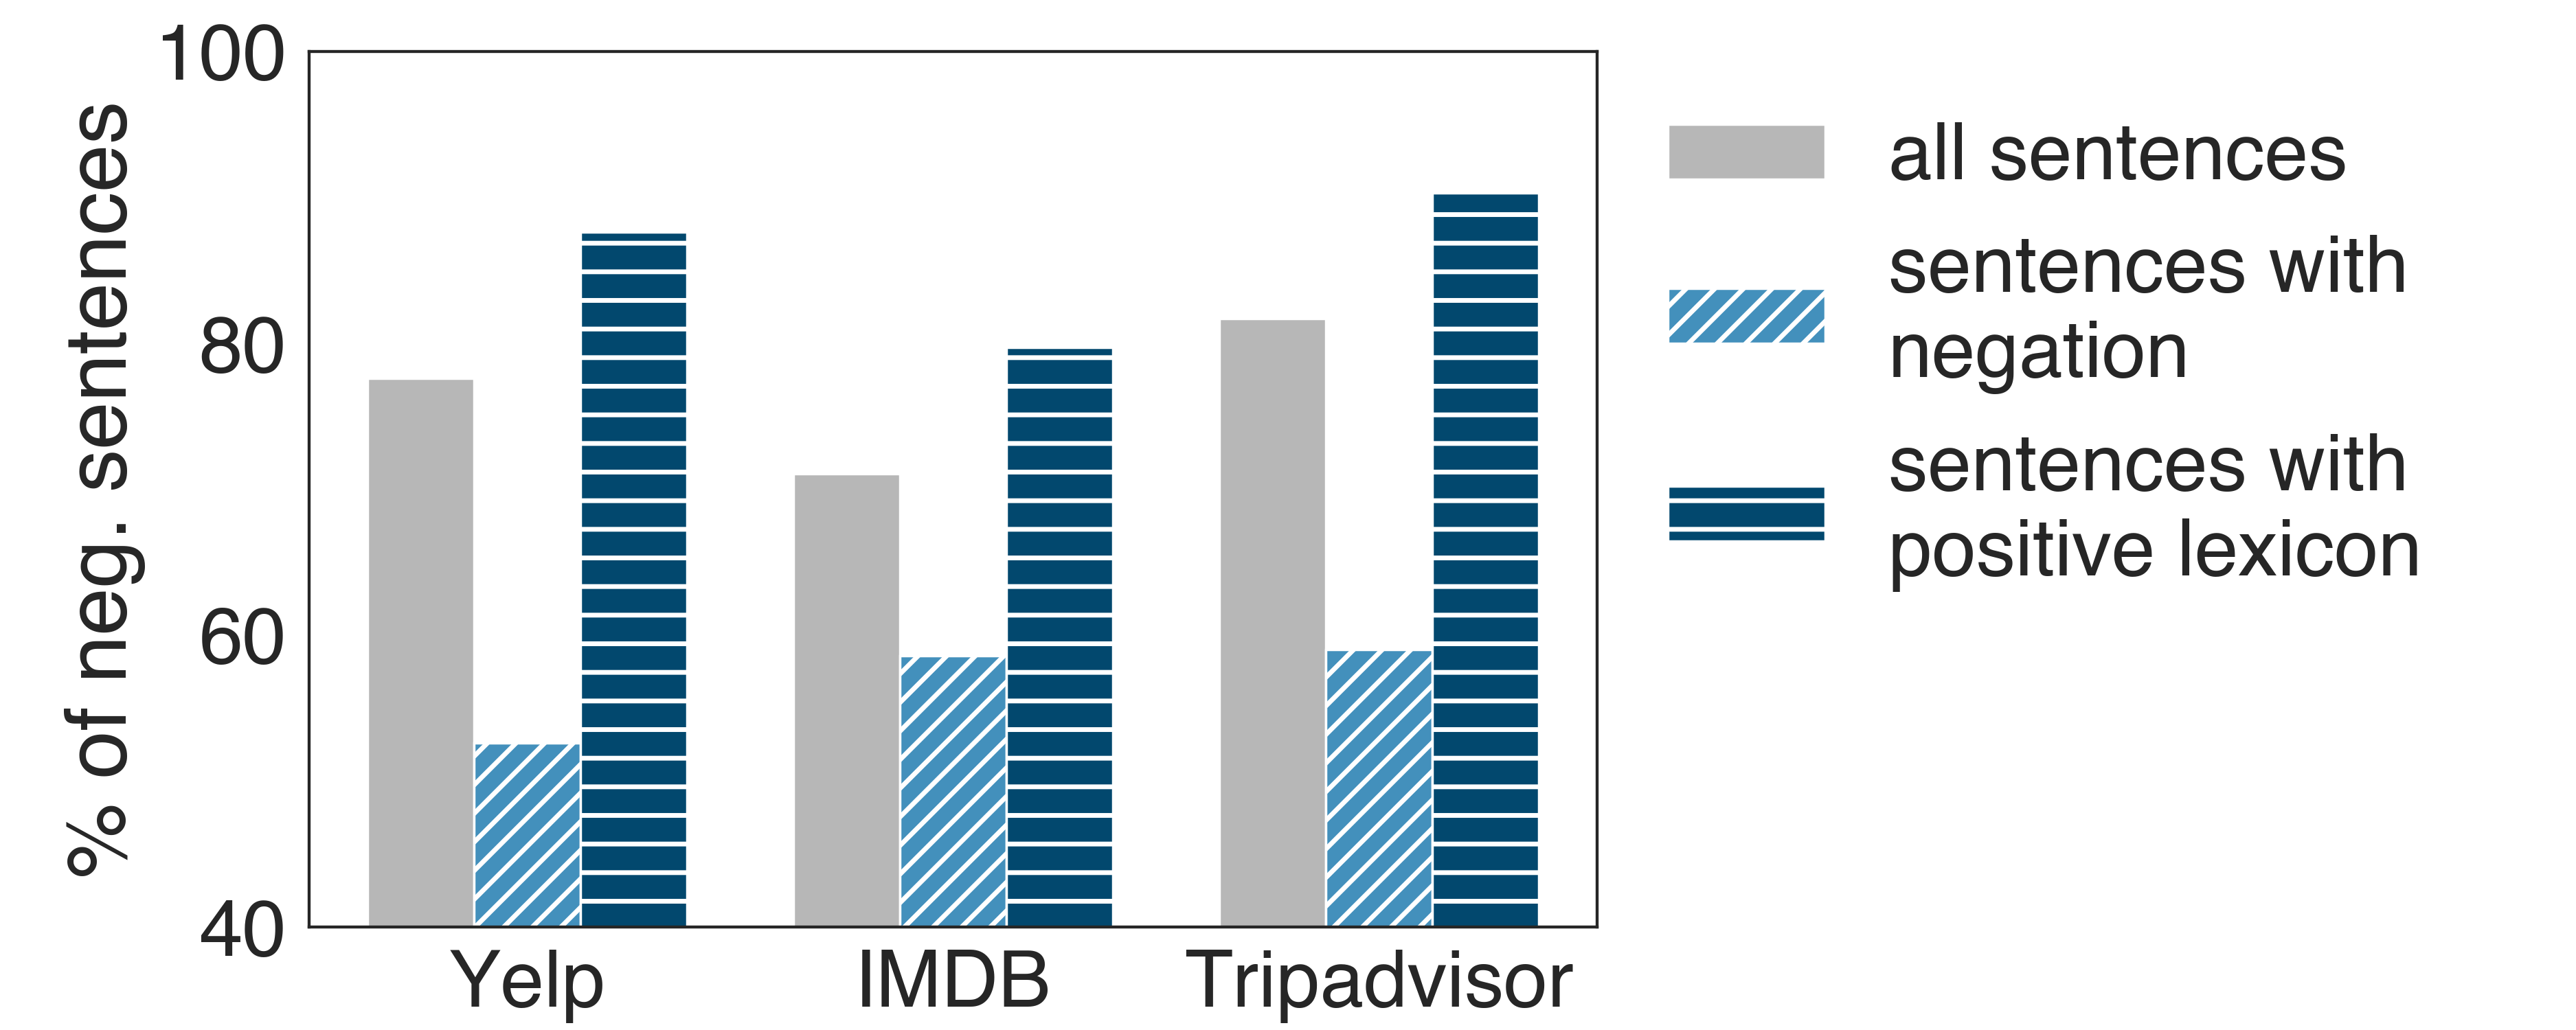

In [3]:
reload(plot_util)

for label in ["negative", "positive"]:
    for correction_score in [True, False]:
        read_and_load_model_outputs(correction_score, label, SENTENCES_TESTING_OUTPUTS_DIR)